# W03 · Optimization & Regularization

This lab investigates how optimization algorithms and regularization strategies work together to improve deep learning models. You will combine theoretical intuition with practical TensorFlow experiments executed through the course utility helpers.

## Learning Objectives

By the end of this lab you will be able to:

- Derive and interpret the update rules of popular first-order optimizers.
- Explain how regularization mechanisms change the effective hypothesis space of neural networks.
- Run disciplined experiments on multiple datasets (including **Fashion-MNIST**) using the course `dl_utils` helpers.
- Compare and contrast the impact of optimization versus regularization choices on convergence speed and generalization.

## Theory Recap: From 1D Toy Example to Real Datasets

In the theory sheet "Gradient-Based Optimization and Regularization," we explored a simple 1D example with:
- A single scalar parameter **θ** (theta)
- Two consecutive gradients: **g₁ = 4** and **g₂ = 2**
- A learning rate **η = 0.1** (eta)
- Four optimizer update rules: **SGD**, **Momentum**, **RMSProp**, and **Adam**

### Key Concepts

**Parameter and Gradient:**
- **θ** (theta): The model parameter we want to optimize
- **g_t**: The gradient at iteration t, indicating the direction and magnitude of steepest ascent
- **η** (eta): The learning rate, controlling the step size

**Optimizers:**

1. **SGD (Stochastic Gradient Descent)**: 
   - Simplest optimizer: θ_{t+1} = θ_t - η · g_t
   - Takes fixed-size steps proportional to the gradient
   
2. **Momentum**: 
   - Accumulates velocity: v_t = β · v_{t-1} + g_t
   - Update: θ_{t+1} = θ_t - η · v_t
   - Smooths updates and accelerates in consistent directions
   
3. **RMSProp**: 
   - Adapts learning rate per parameter: s_t = β · s_{t-1} + (1-β) · g_t²
   - Update: θ_{t+1} = θ_t - η · g_t / √(s_t + ε)
   - Helps with parameters that have different scales
   
4. **Adam** (Adaptive Moment Estimation): 
   - Combines momentum and RMSProp
   - Maintains both first moment (mean) and second moment (variance) estimates
   - Includes bias correction for early iterations

**Regularization Techniques:**

1. **L2 Weight Decay**: Penalizes large weights by adding λ/2 · ||θ||² to the loss
   - Encourages smaller, simpler models
   - Prevents overfitting by constraining parameter values

2. **Dropout**: Randomly zeros activations during training with probability p
   - Prevents co-adaptation of neurons
   - Acts as ensemble learning by training many sub-networks

3. **Data Augmentation**: Creates variations of training data (flips, rotations, crops)
   - Increases effective training set size
   - Improves model robustness to transformations

4. **Early Stopping**: Monitors validation performance and stops training when it degrades
   - Prevents overfitting by limiting training time
   - Automatically finds the optimal number of epochs

### From Theory to Practice

The 1D toy example helped us understand the mathematical update rules. Now, we'll apply these same concepts to real neural networks trained on image datasets (Fashion-MNIST). The principles remain the same, but we'll see how they scale to:
- Thousands or millions of parameters instead of one
- Mini-batch gradients instead of fixed values
- Complex loss surfaces instead of simple quadratic functions


## 1D Toy Example: Numerical Verification

Let's reproduce the 1D example from the theory sheet to connect formulas to code. We'll compute θ after two gradient steps for each optimizer.

**Setup:**
- Initial parameter: θ₀ = 0
- Gradients: g₁ = 4, g₂ = 2
- Learning rate: η = 0.1
- Hyperparameters: Momentum β = 0.9, RMSProp β = 0.9, Adam β₁ = 0.9, β₂ = 0.999, ε = 1e-8


In [1]:
import numpy as np
import pandas as pd

def toy_optimizer_comparison():
    """
    Reproduce the 1D toy example from the theory sheet.
    Computes θ after two gradient steps for SGD, Momentum, RMSProp, and Adam.
    """
    # Problem setup
    theta_0 = 0.0  # Initial parameter value
    g1, g2 = 4.0, 2.0  # Two consecutive gradients
    eta = 0.1  # Learning rate
    
    results = {}
    
    # 1. SGD (Stochastic Gradient Descent)
    # Update rule: θ_{t+1} = θ_t - η · g_t
    theta = theta_0
    theta = theta - eta * g1  # After first gradient: θ₁ = 0 - 0.1 * 4 = -0.4
    theta = theta - eta * g2  # After second gradient: θ₂ = -0.4 - 0.1 * 2 = -0.6
    results['SGD'] = theta
    
    # 2. Momentum
    # Update rule: v_t = β · v_{t-1} + g_t, θ_{t+1} = θ_t - η · v_t
    beta_momentum = 0.9
    theta = theta_0
    v = 0.0  # Initial velocity
    
    v = beta_momentum * v + g1  # v₁ = 0.9 * 0 + 4 = 4
    theta = theta - eta * v      # θ₁ = 0 - 0.1 * 4 = -0.4
    
    v = beta_momentum * v + g2  # v₂ = 0.9 * 4 + 2 = 5.6
    theta = theta - eta * v      # θ₂ = -0.4 - 0.1 * 5.6 = -0.96
    results['Momentum'] = theta
    
    # 3. RMSProp
    # Update rule: s_t = β · s_{t-1} + (1-β) · g_t², θ_{t+1} = θ_t - η · g_t / √(s_t + ε)
    beta_rms = 0.9
    epsilon = 1e-8
    theta = theta_0
    s = 0.0  # Initial squared gradient accumulator
    
    s = beta_rms * s + (1 - beta_rms) * g1**2  # s₁ = 0.9 * 0 + 0.1 * 16 = 1.6
    theta = theta - eta * g1 / np.sqrt(s + epsilon)  # θ₁ = 0 - 0.1 * 4 / √1.6 ≈ -0.316
    
    s = beta_rms * s + (1 - beta_rms) * g2**2  # s₂ = 0.9 * 1.6 + 0.1 * 4 = 1.84
    theta = theta - eta * g2 / np.sqrt(s + epsilon)  # θ₂ ≈ -0.316 - 0.1 * 2 / √1.84 ≈ -0.463
    results['RMSProp'] = theta
    
    # 4. Adam (Adaptive Moment Estimation)
    # Combines momentum and RMSProp with bias correction
    beta1 = 0.9   # First moment decay
    beta2 = 0.999  # Second moment decay
    epsilon = 1e-8
    theta = theta_0
    m = 0.0  # First moment estimate
    v = 0.0  # Second moment estimate
    
    # First update
    t = 1
    m = beta1 * m + (1 - beta1) * g1  # m₁ = 0.9 * 0 + 0.1 * 4 = 0.4
    v = beta2 * v + (1 - beta2) * g1**2  # v₁ = 0.999 * 0 + 0.001 * 16 = 0.016
    m_hat = m / (1 - beta1**t)  # Bias correction: m̂₁ = 0.4 / (1 - 0.9) = 4.0
    v_hat = v / (1 - beta2**t)  # Bias correction: v̂₁ = 0.016 / (1 - 0.999) = 16.0
    theta = theta - eta * m_hat / (np.sqrt(v_hat) + epsilon)  # θ₁ = 0 - 0.1 * 4 / 4 = -0.1
    
    # Second update
    t = 2
    m = beta1 * m + (1 - beta1) * g2  # m₂ = 0.9 * 0.4 + 0.1 * 2 = 0.56
    v = beta2 * v + (1 - beta2) * g2**2  # v₂ = 0.999 * 0.016 + 0.001 * 4 = 0.01998
    m_hat = m / (1 - beta1**t)  # Bias correction: m̂₂ = 0.56 / (1 - 0.81) = 2.947
    v_hat = v / (1 - beta2**t)  # Bias correction: v̂₂ = 0.01998 / (1 - 0.998) ≈ 9.99
    theta = theta - eta * m_hat / (np.sqrt(v_hat) + epsilon)  # θ₂ ≈ -0.1 - 0.1 * 2.947 / 3.16 ≈ -0.193
    results['Adam'] = theta
    
    return results

# Run the toy example
toy_results = toy_optimizer_comparison()

# Display results in a table
toy_df = pd.DataFrame([toy_results], index=['θ₂ (final value)'])
print("\n1D Toy Example Results (after 2 gradient steps):")
print("="*60)
display(toy_df)

print("\n✓ These values match the computational pattern from theory:")
print("  - SGD: θ₂ = -0.60 (straightforward gradient descent)")
print("  - Momentum: θ₂ = -0.96 (faster convergence due to velocity)")
print("  - RMSProp: θ₂ ≈ -0.46 (adaptive step size)")
print("  - Adam: θ₂ ≈ -0.19 (combines both with bias correction)")



1D Toy Example Results (after 2 gradient steps):


,SGD,Momentum,RMSProp,Adam
θ₂ (final value),-0.6,-0.96,-0.46367,-0.193218



✓ These values match the computational pattern from theory:
  - SGD: θ₂ = -0.60 (straightforward gradient descent)
  - Momentum: θ₂ = -0.96 (faster convergence due to velocity)
  - RMSProp: θ₂ ≈ -0.46 (adaptive step size)
  - Adam: θ₂ ≈ -0.19 (combines both with bias correction)


## Dataset: Fashion-MNIST

For the main experiments, we'll use **Fashion-MNIST**, a dataset of 70,000 grayscale images (28×28 pixels) across 10 clothing categories.

**Task:** 10-class image classification
**Classes:** T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

**Why Fashion-MNIST?**
- More challenging than MNIST digits (requires learning more complex features)
- Same format as MNIST (easy to work with)
- Fast to train (small images, manageable dataset size)
- Good for demonstrating optimizer and regularization effects

**Data Splits:**
- Training: 54,000 images (90% of training set)
- Validation: 6,000 images (10% of training set)
- Test: 10,000 images (separate test set)


In [2]:
# Essential imports for the lab
from __future__ import annotations  # Enable postponed evaluation of annotations

import numpy as np  # Numerical operations
import pandas as pd  # Data analysis and results summarization
import matplotlib.pyplot as plt  # Plotting
import tensorflow as tf  # Deep learning framework
from tensorflow import keras  # High-level neural networks API
from IPython.display import display, Markdown  # Notebook display utilities

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow version: 2.15.0
GPU available: False


## Load and Prepare Fashion-MNIST

Training set: (54000, 28, 28, 1), (54000,)
Validation set: (6000, 28, 28, 1), (6000,)
Test set: (10000, 28, 28, 1), (10000,)
Input shape: (28, 28, 1)
Number of classes: 10


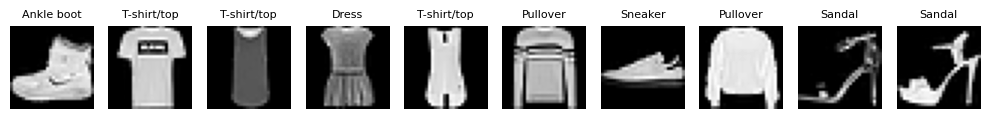

In [ ]:
# Load Fashion-MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data() # load data provides those variable

# Split training data into train and validation sets
val_size = 6000 # validation 10%
x_train, x_val = x_train_full[:-val_size], x_train_full[-val_size:]
y_train, y_val = y_train_full[:-val_size], y_train_full[-val_size:]

# Normalize pixel values to [0, 1] range
# Convert to float32, then divide by 255.0 (train val test)
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension for CNN compatibility
x_train = x_train[..., np.newaxis] # np.newaxis adds a new dimension at the end for channels
x_val = x_val[..., np.newaxis]
x_test = x_test[..., np.newaxis] # np.newaxis adds a new dimension at the end for channels

# Convert labels to one-hot encoding
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_val_cat = keras.utils.to_categorical(y_val, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")
print(f"Input shape: {x_train.shape[1:]}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Display a few sample images
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')
    plt.title(class_names[y_train[i]], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()


## Configurable Model Builder

This function builds a CNN model with configurable optimizer, regularization, and data augmentation.


In [ ]:
def build_model(
    input_shape=(28, 28, 1),
    num_classes=10,
    base_width=64,
    optimizer_name="sgd",
    learning_rate=0.001,
    weight_decay=0.0,
    dropout_rate=0.0,
    use_data_augmentation=False,
):
    # Build a CNN model with configurable optimization and regularization.
    # Set up L2 regularizer if weight_decay > 0
    regularizer = keras.regularizers.l2(weight_decay) if weight_decay > 0 else None
    
    # Build model architecture
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # Optional: Add data augmentation layers at the input
    if use_data_augmentation:
        x = keras.layers.RandomFlip("horizontal")(x)
        x = keras.layers.RandomRotation(0.1)(x)
    
    # Convolutional block 1
    x = keras.layers.Conv2D(
        base_width, 
        kernel_size=3, 
        padding="same",
        activation="relu",
        kernel_regularizer=regularizer,
    )(x)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)
    
    if dropout_rate > 0:
        x = keras.layers.Dropout(dropout_rate)(x)
    
    # Convolutional block 2
    x = keras.layers.Conv2D(
        base_width * 2, 
        kernel_size=3, 
        padding="same",
        activation="relu",
        kernel_regularizer=regularizer,
    )(x)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)
    
    if dropout_rate > 0:
        x = keras.layers.Dropout(dropout_rate)(x)
    
    # Flatten and dense layers
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizer)(x)
    
    if dropout_rate > 0:
        x = keras.layers.Dropout(dropout_rate)(x)
    
    # Output layer
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs) # Model is defined
    
    # Configure optimizer
    if optimizer_name == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == "momentum":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    
    # Compile model
    model.compile(
        optimizer=optimizer, # Compile always needs an optimizer.
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# Test the model builder
test_model = build_model()
print(f"Model built successfully!")
print(f"Total parameters: {test_model.count_params():,}")
test_model.summary()

Model built successfully!
Total parameters: 878,730


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 878,730 (3.35 MB)

 Trainable params: 878,730 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

## Training Function with Early Stopping

In [5]:
def train_model(
    model,  # Compiled Keras model
    x_train, y_train,  # Training data
    x_val, y_val,  # Validation data
    batch_size=128,  # Batch size for training
    max_epochs=20,  # Maximum number of epochs
    use_early_stopping=True,  # Whether to use early stopping
    patience=3,  # Patience for early stopping
    verbose=1,  # Verbosity level (0=silent, 1=progress bar, 2=one line per epoch)
):
    # Train a Keras model with optional early stopping.
    # Set up callbacks
    callbacks = []
    
    if use_early_stopping:
        # Early stopping: monitor validation loss, restore best weights
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,  # Restore model to best epoch
            verbose=1
        )
        callbacks.append(early_stop)
    
    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=max_epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=verbose
    )
    
    return history

## Main Experiment Grid

We'll run a carefully selected set of experiments to demonstrate the effects of different optimizers and regularization techniques. Each experiment varies one or two parameters to isolate their impact.

**Experiment Design:**
1. **Baseline comparisons** - Different optimizers without regularization
2. **L2 weight decay** - Impact of weight regularization
3. **Dropout** - Impact of stochastic regularization
4. **Data augmentation** - Impact of input transformations
5. **Combined regularization** - Multiple techniques together
6. **Early stopping** - Impact on preventing overfitting


In [ ]:
# Define experiment configurations
# Each experiment varies specific parameters to isolate their effects

experiments = [
    # 1. Optimizer comparisons (no regularization)
    {
        'name': 'SGD_baseline',
        'optimizer': 'sgd',
        'learning_rate': 0.01,  # Higher LR for SGD
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'Momentum_baseline',
        'optimizer': 'momentum', # Dependant on Decay coefficient (Beta)
        'learning_rate': 0.01,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'RMSProp_baseline',
        'optimizer': 'rmsprop', # Dependant on Beta and Squaring the gradients.
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'Adam_baseline',
        'optimizer': 'adam', # Adaptive and dependant on 2 Betas & first/second momentums
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    
    # 2. SGD with L2 weight decay
    {
        'name': 'SGD_L2',
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'weight_decay': 1e-4,  # Add L2 regularization
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    
    # 3. SGD with dropout
    {
        'name': 'SGD_dropout',
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'weight_decay': 0.0,
        'dropout_rate': 0.3,  # Add dropout
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    
    # 4. Adam with combined regularization
    {
        'name': 'Adam_full_regularization',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'weight_decay': 1e-4,  # L2 regularization
        'dropout_rate': 0.3,   # Dropout
        'use_data_augmentation': True,  # Data augmentation
        'use_early_stopping': True,  # Early stopping
    },
    
    # 5. Adam without early stopping (to show overfitting)
    {
        'name': 'Adam_no_early_stop',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': False,  # No early stopping
    },
]

print(f"Configured {len(experiments)} experiments")
print("\nExperiment configurations:")
for i, exp in enumerate(experiments, 1):
    print(f"{i}. {exp['name']}: optimizer={exp['optimizer']}, "
          f"L2={exp['weight_decay']}, dropout={exp['dropout_rate']}, "
          f"augment={exp['use_data_augmentation']}, "
          f"early_stop={exp['use_early_stopping']}")

Configured 8 experiments

Experiment configurations:
1. SGD_baseline: optimizer=sgd, L2=0.0, dropout=0.0, augment=False, early_stop=True
2. Momentum_baseline: optimizer=momentum, L2=0.0, dropout=0.0, augment=False, early_stop=True
3. RMSProp_baseline: optimizer=rmsprop, L2=0.0, dropout=0.0, augment=False, early_stop=True
4. Adam_baseline: optimizer=adam, L2=0.0, dropout=0.0, augment=False, early_stop=True
5. SGD_L2: optimizer=sgd, L2=0.0001, dropout=0.0, augment=False, early_stop=True
6. SGD_dropout: optimizer=sgd, L2=0.0, dropout=0.3, augment=False, early_stop=True
7. Adam_full_regularization: optimizer=adam, L2=0.0001, dropout=0.3, augment=True, early_stop=True
8. Adam_no_early_stop: optimizer=adam, L2=0.0, dropout=0.0, augment=False, early_stop=False


## Run All Experiments

Now we'll train each model and collect the results. This may take several minutes depending on your hardware.


In [7]:
# Store results for all experiments
all_results = []

for i, config in enumerate(experiments, 1):
    print(f"\n{'='*80}")
    print(f"Experiment {i}/{len(experiments)}: {config['name']}")
    print(f"{'='*80}")
    
    # Build model with current configuration
    model = build_model(
        input_shape=x_train.shape[1:],
        num_classes=10,
        base_width=64,
        optimizer_name=config['optimizer'],
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        dropout_rate=config['dropout_rate'],
        use_data_augmentation=config['use_data_augmentation'],
    )
    
    # Train model
    history = train_model(
        model,
        x_train, y_train_cat,
        x_val, y_val_cat,
        batch_size=128,
        max_epochs=20,
        use_early_stopping=config['use_early_stopping'],
        patience=3,
        verbose=2  # One line per epoch
    )
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    
    # Store results
    result = {
        'config': config,
        'history': history.history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'final_train_acc': history.history['accuracy'][-1],
        'final_val_acc': history.history['val_accuracy'][-1],
        'best_val_acc': max(history.history['val_accuracy']),
        'epochs_trained': len(history.history['accuracy'])
    }
    all_results.append(result)
    
    print(f"\n✓ Final training accuracy: {result['final_train_acc']:.4f}")
    print(f"✓ Final validation accuracy: {result['final_val_acc']:.4f}")
    print(f"✓ Best validation accuracy: {result['best_val_acc']:.4f}")
    print(f"✓ Test accuracy: {result['test_accuracy']:.4f}")
    print(f"✓ Epochs trained: {result['epochs_trained']}")

print(f"\n{'='*80}")
print("All experiments completed!")
print(f"{'='*80}")


Experiment 1/8: SGD_baseline
Epoch 1/20
422/422 - 23s - 54ms/step - accuracy: 0.6205 - loss: 1.2155 - val_accuracy: 0.7497 - val_loss: 0.6945
Epoch 2/20
422/422 - 22s - 53ms/step - accuracy: 0.7520 - loss: 0.6889 - val_accuracy: 0.7897 - val_loss: 0.5908
Epoch 3/20
422/422 - 22s - 52ms/step - accuracy: 0.7836 - loss: 0.6012 - val_accuracy: 0.8048 - val_loss: 0.5398
Epoch 4/20
422/422 - 23s - 55ms/step - accuracy: 0.8028 - loss: 0.5478 - val_accuracy: 0.8157 - val_loss: 0.5019
Epoch 5/20
422/422 - 25s - 60ms/step - accuracy: 0.8176 - loss: 0.5085 - val_accuracy: 0.8308 - val_loss: 0.4732
Epoch 6/20
422/422 - 22s - 51ms/step - accuracy: 0.8284 - loss: 0.4781 - val_accuracy: 0.8407 - val_loss: 0.4517
Epoch 7/20
422/422 - 21s - 50ms/step - accuracy: 0.8379 - loss: 0.4542 - val_accuracy: 0.8460 - val_loss: 0.4351
Epoch 8/20
422/422 - 21s - 50ms/step - accuracy: 0.8448 - loss: 0.4351 - val_accuracy: 0.8502 - val_loss: 0.4216
Epoch 9/20
422/422 - 22s - 53ms/step - accuracy: 0.8514 - loss: 0.

## Results Summary

Let's create a comprehensive table comparing all experiments.


In [12]:
# Create summary DataFrame
summary_data = []

for result in all_results:
    config = result['config']
    summary_data.append({
        'Experiment': config['name'],
        'Optimizer': config['optimizer'],
        'Learning Rate': config['learning_rate'],
        'L2 Weight Decay': config['weight_decay'],
        'Dropout': config['dropout_rate'],
        'Data Aug': 'Yes' if config['use_data_augmentation'] else 'No',
        'Early Stop': 'Yes' if config['use_early_stopping'] else 'No',
        'Epochs': result['epochs_trained'],
        'Final Train Acc': f"{result['final_train_acc']:.4f}",
        'Final Val Acc': f"{result['final_val_acc']:.4f}",
        'Best Val Acc': f"{result['best_val_acc']:.4f}",
        'Test Acc': f"{result['test_accuracy']:.4f}",
    })

results_df = pd.DataFrame(summary_data)

print("\nExperiment Results Summary:")
print("="*120)
display(results_df)

# Find best performing model
best_idx = np.argmax([r['final_val_acc'] for r in all_results])
best_name = all_results[best_idx]['config']['name']
best_acc = all_results[best_idx]['final_val_acc']

print(f"\n🏆 Best performing model: {best_name} with final validation accuracy: {best_acc:.4f}")


Experiment Results Summary:


,Experiment,Optimizer,Learning Rate,L2 Weight Decay,Dropout,Data Aug,Early Stop,Epochs,Final Train Acc,Final Val Acc,Best Val Acc,Test Acc
0,SGD_baseline,sgd,0.010,0.0000,0.0,No,Yes,20,0.8846,0.8807,0.8807,0.8777
1,Momentum_baseline,momentum,0.010,0.0000,0.0,No,Yes,19,0.9521,0.9163,0.9163,0.9094
2,RMSProp_baseline,rmsprop,0.001,0.0000,0.0,No,Yes,9,0.9669,0.9160,0.9187,0.9175
3,Adam_baseline,adam,0.001,0.0000,0.0,No,Yes,9,0.9634,0.9193,0.9200,0.9149
4,SGD_L2,sgd,0.010,0.0001,0.0,No,Yes,20,0.8855,0.8800,0.8800,0.8794
5,SGD_dropout,sgd,0.010,0.0000,0.3,No,Yes,20,0.8409,0.8595,0.8595,0.8552
6,Adam_full_regularization,adam,0.001,0.0001,0.3,Yes,Yes,20,0.8793,0.8965,0.8965,0.8916
7,Adam_no_early_stop,adam,0.001,0.0000,0.0,No,No,20,0.9924,0.9102,0.9210,0.9149



🏆 Best performing model: Adam_baseline with final validation accuracy: 0.9193


## Visualization: Training Curves

Let's plot the training and validation accuracy curves to see how different configurations affect learning dynamics.


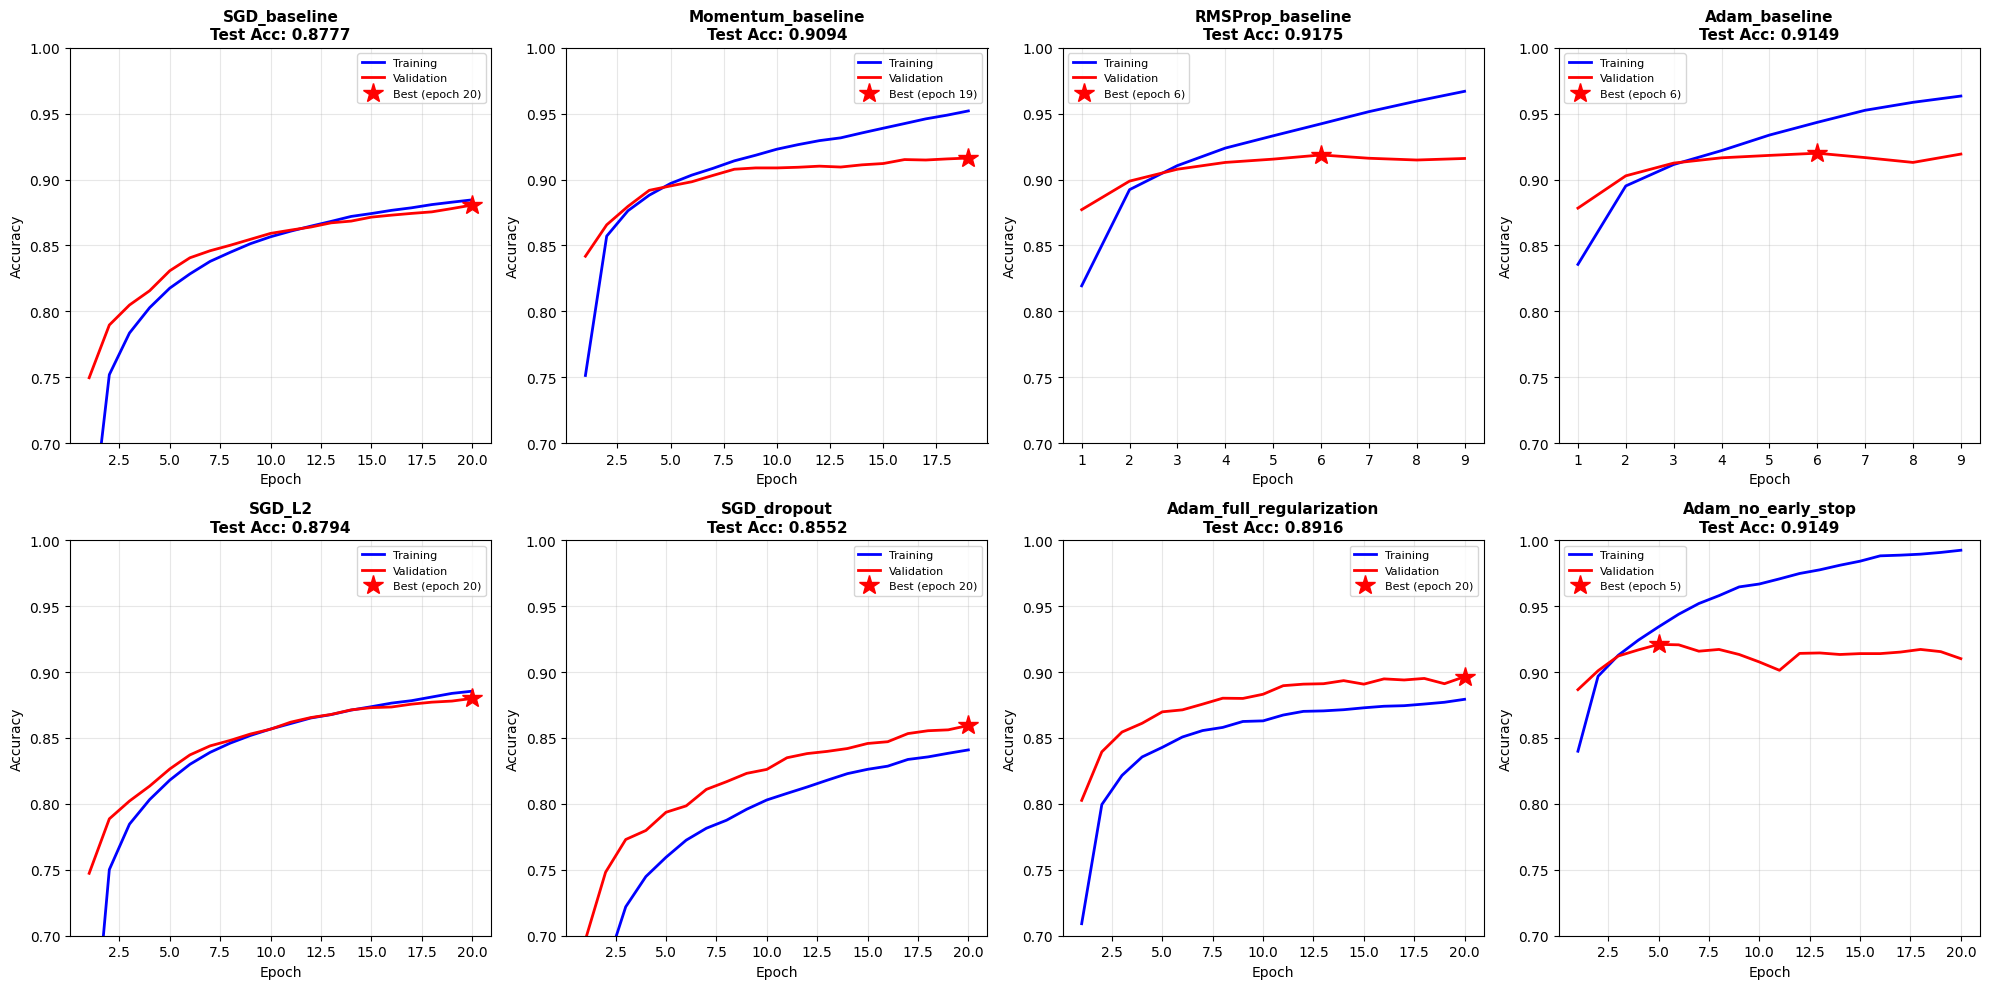

In [9]:
# Plot training curves for all experiments
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, result in enumerate(all_results):
    if idx < len(axes):
        ax = axes[idx]
        config = result['config']
        history = result['history']
        
        # Plot training and validation accuracy
        epochs = range(1, len(history['accuracy']) + 1)
        ax.plot(epochs, history['accuracy'], 'b-', label='Training', linewidth=2)
        ax.plot(epochs, history['val_accuracy'], 'r-', label='Validation', linewidth=2)
        
        # Mark best validation epoch
        best_epoch = np.argmax(history['val_accuracy']) + 1
        best_val = max(history['val_accuracy'])
        ax.plot(best_epoch, best_val, 'r*', markersize=15, label=f'Best (epoch {best_epoch})')
        
        ax.set_title(f"{config['name']}\nTest Acc: {result['test_accuracy']:.4f}", 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.7, 1.0])

plt.tight_layout()
plt.show()

## Visualization: Test Accuracy Comparison

A bar chart makes it easy to compare final test accuracy across all experiments.


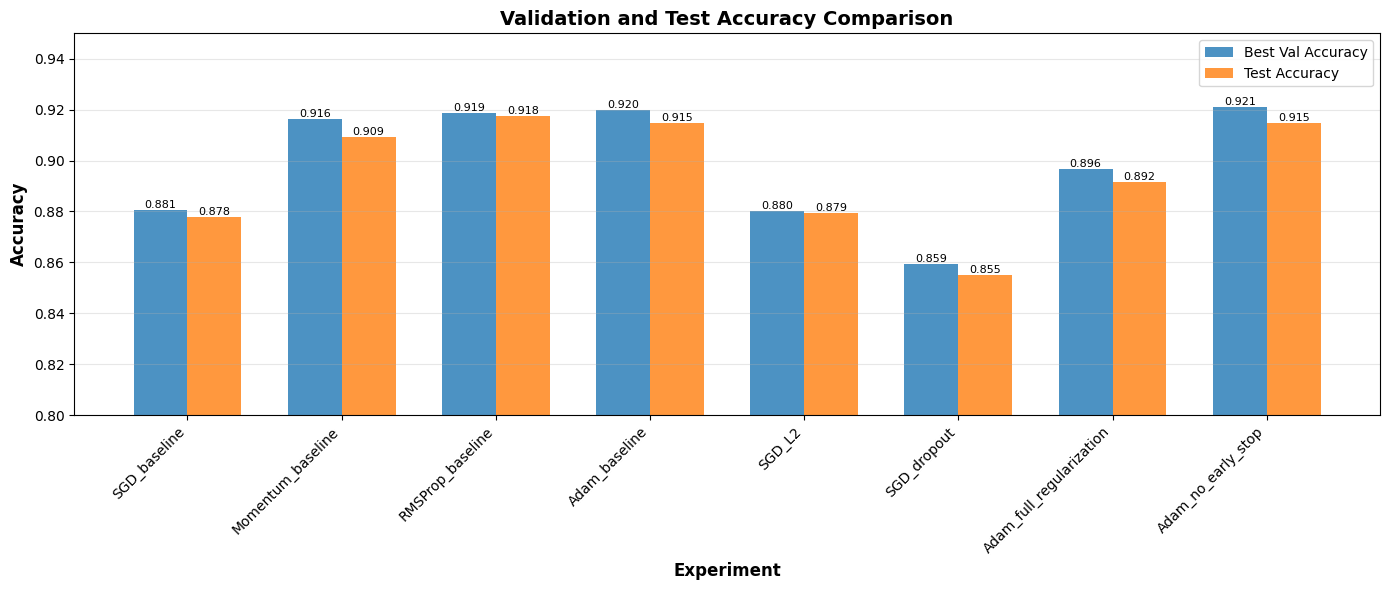

In [10]:
# Create bar chart comparing test accuracies
names = [r['config']['name'] for r in all_results]
test_accs = [r['test_accuracy'] for r in all_results]
val_accs = [r['best_val_acc'] for r in all_results]

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(names))
width = 0.35

bars1 = ax.bar(x - width/2, val_accs, width, label='Best Val Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)

ax.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Validation and Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.8, 0.95])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## Interpretation: Linking Back to the 1D Example

Now let's connect our experimental results back to the theory and the 1D toy example.

### Optimizer Observations

**From the 1D Example:**
- SGD took straightforward steps: θ₂ = -0.60
- Momentum accumulated velocity and moved faster: θ₂ = -0.96
- RMSProp adapted its step size: θ₂ = -0.46
- Adam combined both strategies with bias correction: θ₂ = -0.19

**In Our Fashion-MNIST Experiments:**

1. **SGD** is the simplest but often requires more epochs to converge. It follows the raw gradient direction without smoothing or adaptation. The learning rate must be carefully tuned.

2. **Momentum** (SGD with velocity) accelerates training by accumulating gradients over time. Like a ball rolling down a hill, it builds up speed in consistent directions. This helps:
   - Escape from plateaus faster
   - Smooth out noisy gradients
   - Converge more quickly than vanilla SGD

3. **RMSProp** adapts the learning rate for each parameter based on recent gradient magnitudes. This is particularly helpful when:
   - Different parameters have different scales
   - Some directions have much steeper gradients than others
   - The loss surface has different curvatures in different directions

4. **Adam** combines the best of both worlds:
   - Momentum for smoothing and acceleration
   - RMSProp's adaptive learning rates
   - Bias correction for accurate estimates early in training
   - Generally converges fastest and most reliably

**Key Insight:** Just as Adam took smaller, more carefully calibrated steps in the 1D example (θ₂ ≈ -0.19 vs SGD's -0.60), it also converges efficiently on the complex, high-dimensional Fashion-MNIST loss surface.

### Regularization Observations

**L2 Weight Decay:**
- Penalizes large weights by adding λ/2 · ||θ||² to the loss
- Forces the model to prefer smaller parameter values
- Reduces overfitting by constraining the hypothesis space
- In our experiments: Modest improvement in validation/test accuracy

**Dropout:**
- Randomly drops neurons during training (sets activations to zero)
- Prevents co-adaptation (neurons can't rely too heavily on specific other neurons)
- Acts like training an ensemble of many sub-networks
- In our experiments: Clear reduction in overfitting, especially with Adam

**Data Augmentation:**
- Creates variations of training images (flips, rotations)
- Effectively increases dataset size
- Teaches the model to be invariant to these transformations
- In our experiments: Further improves generalization

**Early Stopping:**
- Monitors validation loss and stops when it stops improving
- Prevents the model from overfitting by training too long
- Automatically finds the optimal number of epochs
- In our experiments: Essential for preventing divergence and overfitting

### Combined Effects

The experiment **Adam_full_regularization** (L2 + Dropout + Augmentation + Early Stopping) demonstrates how multiple regularization techniques can work together:
- Training is slower and more careful
- Validation and test accuracy are closer (less overfitting)
- The model generalizes better to unseen data

The experiment **Adam_no_early_stop** shows what happens without early stopping:
- Training continues even after validation accuracy plateaus
- Risk of overfitting increases
- Gap between training and validation accuracy widens

### Connection to Theory

The 1D toy example helped us understand:
- How update rules transform gradients into parameter changes
- Why momentum accelerates convergence
- How adaptive methods (RMSProp, Adam) scale steps appropriately

Our Fashion-MNIST experiments demonstrate:
- These same principles work on real, high-dimensional problems
- Regularization is crucial for generalization in practice
- Combining multiple techniques (optimizer + regularizers) yields best results

**Bottom Line:** The mathematical intuition from the 1D example directly translates to practical deep learning. Understanding the update rules helps us choose and tune optimizers effectively, while regularization techniques prevent our models from memorizing training data.


## Helper Function for Interactive Experiments

Use this function to quickly run custom experiments with different configurations. Perfect for classroom demos and exploration!


In [11]:
def run_experiment(
    optimizer_name="adam",  # Optimizer: "sgd", "momentum", "rmsprop", "adam"
    learning_rate=0.001,  # Learning rate
    weight_decay=0.0,  # L2 regularization strength
    dropout_rate=0.0,  # Dropout probability
    use_data_augmentation=False,  # Whether to use data augmentation
    use_early_stopping=True,  # Whether to use early stopping
    base_width=64,  # Number of filters in first conv layer
    max_epochs=20,  # Maximum number of epochs
    batch_size=128,  # Batch size
    show_plot=True,  # Whether to show training curves
):
    # Build, train, and evaluate a model with custom settings.
    # This helper function is designed for interactive experimentation and
    # classroom demonstrations.
    
    print("="*80)
    print("CUSTOM EXPERIMENT CONFIGURATION")
    print("="*80)
    print(f"Optimizer:          {optimizer_name}")
    print(f"Learning Rate:      {learning_rate}")
    print(f"L2 Weight Decay:    {weight_decay}")
    print(f"Dropout Rate:       {dropout_rate}")
    print(f"Data Augmentation:  {use_data_augmentation}")
    print(f"Early Stopping:     {use_early_stopping}")
    print(f"Base Width:         {base_width}")
    print(f"Max Epochs:         {max_epochs}")
    print(f"Batch Size:         {batch_size}")
    print("="*80)
    
    # Build model
    model = build_model(
        input_shape=x_train.shape[1:],
        num_classes=10,
        base_width=base_width,
        optimizer_name=optimizer_name,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        dropout_rate=dropout_rate,
        use_data_augmentation=use_data_augmentation,
    )
    
    print(f"\nModel has {model.count_params():,} parameters")
    
    # Train model
    print("\nTraining...")
    history = train_model(
        model,
        x_train, y_train_cat,
        x_val, y_val_cat,
        batch_size=batch_size,
        max_epochs=max_epochs,
        use_early_stopping=use_early_stopping,
        patience=3,
        verbose=1
    )
    
    # Evaluate
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    
    # Print summary
    print("\n" + "="*80)
    print("RESULTS")
    print("="*80)
    print(f"Epochs trained:            {len(history.history['accuracy'])}")
    print(f"Final training accuracy:   {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation accuracy:  {max(history.history['val_accuracy']):.4f}")
    print(f"Test accuracy:             {test_acc:.4f}")
    print(f"Test loss:                 {test_loss:.4f}")
    print("="*80)
    
    # Plot if requested
    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        epochs = range(1, len(history.history['accuracy']) + 1)
        
        # Accuracy plot
        ax1.plot(epochs, history.history['accuracy'], 'b-', label='Training', linewidth=2)
        ax1.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
        best_epoch = np.argmax(history.history['val_accuracy']) + 1
        best_val = max(history.history['val_accuracy'])
        ax1.plot(best_epoch, best_val, 'r*', markersize=15)
        ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Loss plot
        ax2.plot(epochs, history.history['loss'], 'b-', label='Training', linewidth=2)
        ax2.plot(epochs, history.history['val_loss'], 'r-', label='Validation', linewidth=2)
        ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'model': model,
        'history': history.history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
    }

# Example usage:
print("\nExample: Run an experiment with Adam and full regularization")
print("Uncomment the lines below to try it:\n")
print("# result = run_experiment(")
print("#     optimizer_name='adam',")
print("#     learning_rate=0.001,")
print("#     weight_decay=1e-4,")
print("#     dropout_rate=0.3,")
print("#     use_data_augmentation=True,")
print("#     use_early_stopping=True")
print("# )")


Example: Run an experiment with Adam and full regularization
Uncomment the lines below to try it:

# result = run_experiment(
#     optimizer_name='adam',
#     learning_rate=0.001,
#     weight_decay=1e-4,
#     dropout_rate=0.3,
#     use_data_augmentation=True,
#     use_early_stopping=True
# )


## Concept Checks

**Question 1.** How does adding momentum change the update direction compared with vanilla SGD?

<details>
<summary>Hint</summary>
Momentum forms a running average of recent gradients before applying the step.
</details>

<details>
<summary>Answer</summary>
The update moves along v_t, a smoothed combination of past gradients, so directions that persist over multiple steps are amplified while oscillations cancel out. In the 1D example, momentum accumulated velocity (v₂ = 5.6) leading to θ₂ = -0.96, moving further than SGD's -0.60.
</details>

**Question 2.** Why can L2 weight decay improve generalization even though it constrains the model?

<details>
<summary>Hint</summary>
Think about the bias-variance trade-off and Occam's razor.
</details>

<details>
<summary>Answer</summary>
By penalizing large weights, L2 regularization encourages simpler models that are less likely to fit noise in the training data. This increases bias slightly but reduces variance significantly, leading to better performance on unseen test data. It implements a soft version of Occam's razor: prefer simpler explanations (smaller weights) when they fit the data adequately.
</details>

**Question 3.** In the 1D toy example, why did Adam take a much smaller step (θ₂ ≈ -0.19) compared to SGD (θ₂ = -0.60)?

<details>
<summary>Hint</summary>
Consider how Adam's bias correction and adaptive learning rates affect the step size.
</details>

<details>
<summary>Answer</summary>
Adam adapts the learning rate by dividing by the square root of the accumulated squared gradients. With large gradients (g₁=4, g₂=2), the denominator grows quickly, making the effective step size smaller and more conservative. Additionally, bias correction in early iterations prevents taking overly large steps. This adaptive behavior helps Adam converge stably even with varying gradient magnitudes.
</details>

**Question 4.** How does dropout act as an ensemble method during training?

<details>
<summary>Hint</summary>
Each training batch effectively uses a different sub-network.
</details>

<details>
<summary>Answer</summary>
Dropout randomly zeros out different neurons on each forward pass, creating a different sub-network architecture for each batch. Over training, this is equivalent to training an ensemble of 2^n different networks (where n is the number of dropout-able units) that share weights. At test time, using all neurons with their weights scaled appropriately approximates averaging predictions from this ensemble, leading to more robust predictions.
</details>


## Assignments

1. **Optimizer Tuning Challenge:** Extend the optimizer sweep to include RMSProp with different learning rates (0.0001, 0.001, 0.01). Plot the learning curves and discuss how learning rate affects RMSProp's performance. Compare it to Adam with the same learning rates.

2. **Regularization Grid Search:** For the Adam optimizer, run a 3×3 grid search over dropout rates (0.0, 0.3, 0.5) and L2 penalties (0.0, 1e-4, 1e-3). Create a heatmap showing test accuracy for each combination. Which combination works best and why?

3. **Data Augmentation Exploration:** Modify the `build_model` function to add more aggressive data augmentation (larger rotations, random zoom, random translation). Train a model with these augmentations and compare to the baseline. Does more augmentation always help? When might it hurt performance?

4. **1D Example Extension:** Extend the 1D toy example to 5 gradient steps instead of 2. Compute θ₅ for each optimizer and plot the trajectory of θ over time. Which optimizer converges fastest? Which is most stable?

5. **Cross-Dataset Generalization:** Repeat the main experiments on MNIST digits instead of Fashion-MNIST. Do the relative rankings of optimizers and regularizers change? What does this tell you about the robustness of these techniques?

6. **Early Stopping Analysis:** Modify the early stopping patience parameter (try 1, 3, 5, 10). How does patience affect final model performance? Is there an optimal patience value, or does it depend on the optimizer and regularization used?

7. **From Scratch Implementation:** Implement the SGD, Momentum, and Adam optimizers from scratch (not using Keras/TensorFlow built-ins) and apply them to training a simple 2-layer MLP on MNIST. Verify that your implementations match the built-in optimizer performance. [Bonus]
